In [1]:
import pandas as pd
import re
pd.set_option("display.max_columns", 500)

## Armado de dataset para entrenamiento del modelo

Se usan ventanas de tiempo de 6 meses para agrupar los datos y predecir la baja dentro de los próximos 6

Training: 
- 1 a 6
- 2 a 7
- 3 a 8

Optimization
- 4 a 9

Validation
- 5 a 10

Test
- 6 a 11
- 7 a 12

In [2]:
df = pd.read_feather('../../../../data/processed/merged_18_periods(BPICS).feather')

### Agregamos periodos faltantes: 
- Situacion PP para 1, 2 y 3
- Agunos tipos de siniestros no estan en todos los periodos

<h4 style="color:red" > Se soluciona agregando las columnas al dataframe lleno de nulls. REVISAR EL SCRIPT ORIGINAL A FUTURO</h4>

In [3]:
import numpy as np

for col in ['1_SITUACION_PP','2_SITUACION_PP','3_SITUACION_PP']:
    df[col] = np.nan

In [4]:
sini_cols = set([''.join([s for s in col if not s.isdigit()]) for col in df[[col for col in df.columns if re.search(f'\d_TIPO_SINI', col)]].columns])

In [5]:
sini_cols

{'_TIPO_SINI_A',
 '_TIPO_SINI_B',
 '_TIPO_SINI_C',
 '_TIPO_SINI_E',
 '_TIPO_SINI_H',
 '_TIPO_SINI_I',
 '_TIPO_SINI_L',
 '_TIPO_SINI_N',
 '_TIPO_SINI_R',
 '_TIPO_SINI_Z'}

In [6]:
for col in sini_cols:
    for i in range(1,13):
        if f'{i}{col}' not in df.columns:
            df[f'{i}{col}'] = np.nan

Verificamos la distribucion de periodos de baja

In [7]:
df["periodo_baja"].value_counts().sort_index().plot.bar()

In [8]:
df["CIF_ID"].isna().sum()

0

### Script de agrupación de registros de acuerdo a las ventanas temporales. El test está en *1. Test to arrange datasets by time periods*

---
** Se agrega calculo de diferencia por periodos de: **
- **Cantidad de polizas**

In [9]:
# Buscamos las features que son periódicas
periodic_cols = set([''.join([s for s in col if not s.isdigit()]) for col in df[[col for col in df.columns if re.search(f'\d', col)]].columns])

# Armamos otro dataframe con todas las features que no son temporales
non_periodic_cols = [col for col in df.columns if not any(char.isdigit() for char in col)]


# Definimos ventana inicial
w_low = 1
w_top = 6
further_periods = 6

final_df = pd.DataFrame()

while(w_low < 8):
    print(f"----------TIME WINDOW: {w_low} a {w_top}-----------")
    # Armamos todo el nuevo dataset del periodo en grouped_df
    grouped_df = df[non_periodic_cols].copy(deep=True)

    #Seleccionamos las features del periodo
    print("Seleccionando features por periodo...                       ", end="\r", flush=True)
    for pcol in periodic_cols:
        regex_range = "|".join([str(i) for i in range(w_low, w_top+1)])
        regex = f'{pcol}({regex_range})$|^({regex_range}){pcol}'
        columns = [col for col in df.columns if re.search(regex, col)]
        grouped_df[[f"{i}_{pcol}" for i in range(6, 0, -1)]] = df[columns]

    # Buscamos los clientes que no tienen polizas en el periodo analizado
    print("Buscando clientes sin polizas...                       ", end="\r", flush=True)
    grouped_df = grouped_df[grouped_df["hist_polizas"].str.split(" ", expand=True).iloc[:,w_low-1:w_top].astype(float).sum(axis=1) > 0]
    
    # Buscamos las polizas que ya se dieron de baja en el periodo analizado
    print("Buscando clientes que ya se dieron de baja...                  ", end="\r", flush=True)
    grouped_df = grouped_df[~grouped_df["periodo_baja"].between(1, w_top)]
    
    # Preparamos columnas de pólizas por período
    print("Preparando pólizas por períodos...                             ", end="\r", flush=True)
    grouped_df[[f"polizas_{i}" for i in range(6, 0, -1)]] = grouped_df["hist_polizas"].str.split(" ", expand=True).iloc[:,w_low-1:w_top].astype(float)
    
    # Calculamos campos adicionales (Diferencias entre periodos)
    print("Preparando campos adicionales...                             ", end="\r", flush=True)
    for i in range(5, 0, -1):
        grouped_df[f"diff_cant_polizas_{i}"] = grouped_df[f"polizas_{i}"] - grouped_df[f"polizas_{i+1}"]    
        current_int = [col for col in grouped_df.columns if re.search(f'({i})__TIPOINT', col)]
        next_int = [col for col in grouped_df.columns if re.search(f'({i+1})__TIPOINT', col)]
        grouped_df[f"diff_cant_int_{i}"] =  grouped_df[current_int].sum(axis=1) - grouped_df[next_int].sum(axis=1)

    # Marcamos periodo de baja
    print("Creando flag de CLTP...                           ", end="\r", flush=True)
    grouped_df["CLTP"] = grouped_df["periodo_baja"].map(lambda x: 0 if (x < 0) or (x > w_top + further_periods) else x - w_low -5)
    
    # Marcamos un flag para saber la ventana de tiempo que se analiza
    print("Creando flag de periodo...                        ", end="\r", flush=True)
    grouped_df["time_window"] = f"{w_low} a {w_top}"

    # Agregamos el tipo de dataset 
    if(w_low < 4):
        grouped_df["dataset"] = 'train'
    elif(w_low == 4):
        grouped_df["dataset"] = 'opt'
    elif(w_low == 5):
        grouped_df["dataset"] = 'val'
    else:
        grouped_df["dataset"] = 'test'
    
    # Agregamos el periodo al datafame final 
    final_df = pd.concat([final_df, grouped_df], ignore_index=True)
    
    del grouped_df
    w_low += 1
    w_top += 1
    print("Next window...                         ")

print("Ready!")

----------TIME WINDOW: 1 a 6-----------
Next window...                                                 
----------TIME WINDOW: 2 a 7-----------
Next window...                                                 
----------TIME WINDOW: 3 a 8-----------
Next window...                                                 
----------TIME WINDOW: 4 a 9-----------
Next window...                                                 
----------TIME WINDOW: 5 a 10-----------
Next window...                                                 
----------TIME WINDOW: 6 a 11-----------
Next window...                                                 
----------TIME WINDOW: 7 a 12-----------
Next window...                                                 
Ready!


In [10]:
final_df[final_df["diff_cant_polizas_4"] > 0]

,CIF_ID,hist_polizas,periodo_baja,index,ORIGEN,SEXO,TIPO_PERSONA,CLIENTE,ANO_DE_NACIMIENTO,FECHA_NACIMIENTO,ESTADO_CIVIL,DATECO_TRABAJA,DATECO_AUTONOMO,DATECO_RAZON_SOCIAL_EMPLEADOR,DATMAR_COMPLETO_ESTUDIOS,DATMAR_NIVEL_EDUCACION,POSICION_IVA,6__TIPO_SINI_R,5__TIPO_SINI_R,4__TIPO_SINI_R,3__TIPO_SINI_R,2__TIPO_SINI_R,1__TIPO_SINI_R,6__TIPO_SINI_B,5__TIPO_SINI_B,4__TIPO_SINI_B,3__TIPO_SINI_B,2__TIPO_SINI_B,1__TIPO_SINI_B,6_demora_pago_,5_demora_pago_,4_demora_pago_,3_demora_pago_,2_demora_pago_,1_demora_pago_,6__SITUACION_EP,5__SITUACION_EP,4__SITUACION_EP,3__SITUACION_EP,2__SITUACION_EP,1__SITUACION_EP,6__SITUACION_CT,5__SITUACION_CT,4__SITUACION_CT,3__SITUACION_CT,2__SITUACION_CT,1__SITUACION_CT,6__TIPO_SINI_A,5__TIPO_SINI_A,4__TIPO_SINI_A,3__TIPO_SINI_A,2__TIPO_SINI_A,1__TIPO_SINI_A,6__TIPO_SINI_L,5__TIPO_SINI_L,4__TIPO_SINI_L,3__TIPO_SINI_L,2__TIPO_SINI_L,1__TIPO_SINI_L,6__TIPOINT_O,5__TIPOINT_O,4__TIPOINT_O,3__TIPOINT_O,2__TIPOINT_O,1__TIPOINT_O,6__COBRO_BA,5__COBRO_BA,4__COBRO_BA,3__COBRO_BA,2__COBRO_BA,1__COBRO_BA,6__TIPOINT_I,5__TIPOINT_I,4__TIPOINT_I,3__TIPOINT_I,2__TIPOINT_I,1__TIPOINT_I,6__TIPO_SINI_C,5__TIPO_SINI_C,4__TIPO_SINI_C,3__TIPO_SINI_C,2__TIPO_SINI_C,1__TIPO_SINI_C,6__TIPO_SINI_I,5__TIPO_SINI_I,4__TIPO_SINI_I,3__TIPO_SINI_I,2__TIPO_SINI_I,1__TIPO_SINI_I,6__TIPO_SINI_H,5__TIPO_SINI_H,4__TIPO_SINI_H,3__TIPO_SINI_H,2__TIPO_SINI_H,1__TIPO_SINI_H,6__SITUACION_PP,5__SITUACION_PP,4__SITUACION_PP,3__SITUACION_PP,2__SITUACION_PP,1__SITUACION_PP,6_periodo_sini_,5_periodo_sini_,4_periodo_sini_,3_periodo_sini_,2_periodo_sini_,1_periodo_sini_,6_MONTO_PAGO_,5_MONTO_PAGO_,4_MONTO_PAGO_,3_MONTO_PAGO_,2_MONTO_PAGO_,1_MONTO_PAGO_,6__COBRO_CC,5__COBRO_CC,4__COBRO_CC,3__COBRO_CC,2__COBRO_CC,1__COBRO_CC,6__COBRO_TA,5__COBRO_TA,4__COBRO_TA,3__COBRO_TA,2__COBRO_TA,1__COBRO_TA,6__COBRO_SJ,5__COBRO_SJ,4__COBRO_SJ,3__COBRO_SJ,2__COBRO_SJ,1__COBRO_SJ,6__COBRO_PP,5__COBRO_PP,4__COBRO_PP,3__COBRO_PP,2__COBRO_PP,1__COBRO_PP,6_periodo_liquidacion_sini_,5_periodo_liquidacion_sini_,4_periodo_liquidacion_sini_,3_periodo_liquidacion_sini_,2_periodo_liquidacion_sini_,1_periodo_liquidacion_sini_,6_periodo_rechazo_sini_,5_periodo_rechazo_sini_,4_periodo_rechazo_sini_,3_periodo_rechazo_sini_,2_periodo_rechazo_sini_,1_periodo_rechazo_sini_,6__TIPOINT_A,5__TIPOINT_A,4__TIPOINT_A,3__TIPOINT_A,2__TIPOINT_A,1__TIPOINT_A,6__TIPO_SINI_E,5__TIPO_SINI_E,4__TIPO_SINI_E,3__TIPO_SINI_E,2__TIPO_SINI_E,1__TIPO_SINI_E,6__SITUACION_AM,5__SITUACION_AM,4__SITUACION_AM,3__SITUACION_AM,2__SITUACION_AM,1__SITUACION_AM,6__TIPO_SINI_Z,5__TIPO_SINI_Z,4__TIPO_SINI_Z,3__TIPO_SINI_Z,2__TIPO_SINI_Z,1__TIPO_SINI_Z,6__TIPO_SINI_N,5__TIPO_SINI_N,4__TIPO_SINI_N,3__TIPO_SINI_N,2__TIPO_SINI_N,1__TIPO_SINI_N,polizas_6,polizas_5,polizas_4,polizas_3,polizas_2,polizas_1,diff_cant_polizas_5,diff_cant_int_5,diff_cant_polizas_4,diff_cant_int_4,diff_cant_polizas_3,diff_cant_int_3,diff_cant_polizas_2,diff_cant_int_2,diff_cant_polizas_1,diff_cant_int_1,CLTP,time_window,dataset
48,37125.0,0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,-1,0.0,082,M,F,None,1968.0,15/02/1968,Casado,S,None,PODER JUDICIAL DE LA NACI,S,UNIVERSITARIO,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.000000,0.509251,0.492823,0.509251,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,3.0,1.0,5.0,8.0,7.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,14.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1995.00,2039.000000,2039.000000,2049.000000,2039.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,17.0,0.0,-9.0,0.0,-2.0,0.0,-3.0,0,1 a 6,train
67,41729.0,1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,-1,0.0,082,M,F,S,1955.0,25/03/1955,Casado,S,None

In [11]:
final_df[final_df["CLTP"]>4]["dataset"].value_counts()

train    32139
test     23739
val      11485
opt      10415
Name: dataset, dtype: int64

In [12]:
final_df = final_df.drop(["CIF_ID","hist_polizas","periodo_baja","index"], axis=1)

In [13]:
(final_df["CLTP"] > 0).value_counts(normalize=True)

False    0.883139
True     0.116861
Name: CLTP, dtype: float64

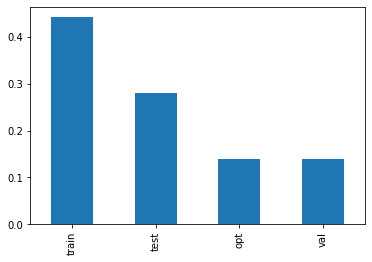

In [14]:
final_df[final_df["CLTP"] > 0]["dataset"].value_counts(normalize=True).plot.bar()

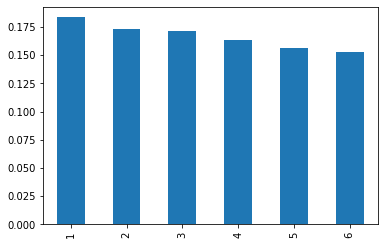

In [15]:
final_df[final_df["CLTP"] > 0]["CLTP"].value_counts(normalize=True).plot.bar()

## Guardamos los datsets

### Train

In [16]:
final_df[final_df['dataset'] == 'train'].drop(columns='dataset').reset_index(drop=True).to_feather("../../../../data/processed/CLTP_train_set.feather")

### Opt

In [17]:
final_df[final_df['dataset'] == 'opt'].drop(columns='dataset').reset_index(drop=True).to_feather("../../../../data/processed/CLTP_optimization_set.feather")

### Val

In [18]:
final_df[final_df['dataset'] == 'val'].drop(columns='dataset').reset_index(drop=True).to_feather("../../../../data/processed/CLTP_validation_set.feather")

### Test

In [19]:
final_df[final_df['dataset'] == 'test'].drop(columns='dataset').reset_index(drop=True).to_feather("../../../../data/processed/CLTP_test_set.feather")